In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ccs.data import ActivationDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

In [3]:
dataset = ActivationDataset("data/boolq/prompts.csv")

In [4]:
confidence_loss = lambda p_plus, p_minus: (torch.min(p_plus, p_minus) ** 2).mean()
consistency_loss = lambda p_plus, p_minus: ((p_plus - (1 - p_minus)) ** 2).mean()

In [5]:
class LinearProbe(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.direction = nn.Linear(dim, 1, bias=True)
    
    def forward(self, x):
        return F.sigmoid(self.direction(x))
    
    def predict(self, x_plus, x_minus):
        p_plus = self(x_plus)
        p_minus = self(x_minus)
        return (p_plus + (1 - p_minus)) / 2

In [6]:
def train_probe(x0, x1, epochs=100, lr=1e-2):
    probe = LinearProbe(x0.shape[-1])
    optimizer = torch.optim.AdamW(probe.parameters(), lr=lr)

    consistency_losses, confidence_losses, losses = [], [], []
    for epoch in range(epochs):
        optimizer.zero_grad()
        p_plus = probe(x0)
        p_minus = probe(x1)
        confidence_l = confidence_loss(p_plus, p_minus)
        consistency_l = consistency_loss(p_plus, p_minus)
        loss = confidence_l + consistency_l
        loss.backward()
        optimizer.step()

        consistency_losses.append(consistency_l.item())
        confidence_losses.append(confidence_l.item())
        losses.append(loss.item())

    return probe, consistency_losses, confidence_losses, losses

In [7]:
def test(probe, x0, x1, y):
    y_hat = probe.predict(x0, x1)
    acc = ((y_hat > 0.5) == y).float().mean().item()
    acc = max(acc, 1 - acc)
    return acc

In [8]:
all_losses, ccs_accs, lr_accs, confusions = [], [], [], []
for layer in trange(1, 33):
    dataset.set_layer(layer)
    x0, x1, y = dataset[:512]
    x0_test, x1_test, y_test = dataset[512:1024]

    probe, consistency_losses, confidence_losses, losses = train_probe(x0, x1, epochs=500, lr=1e-2)
    all_losses.append(losses)
    ccs_accs.append(test(probe, x0, x1, y))
    confusions.append(confusion_matrix(y, (probe.predict(x0, x1) > 0.5).float().numpy()))

    # evaluate LR
    x_all = torch.cat([x0, x1], dim=0)
    y_all = torch.cat([y, 1 - y], dim=0)
    x_all_test = torch.cat([x0_test, x1_test], dim=0)
    y_all_test = torch.cat([y_test, 1 - y_test], dim=0)
    lr = LogisticRegression()
    lr.fit(x_all, y_all)
    lr_accs.append(lr.score(x_all_test, y_all_test))

  0%|          | 0/32 [00:00<?, ?it/s]/opt/conda/envs/ccs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  3%|▎         | 1/32 [00:02<01:26,  2.78s/it]/opt/conda/envs/ccs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

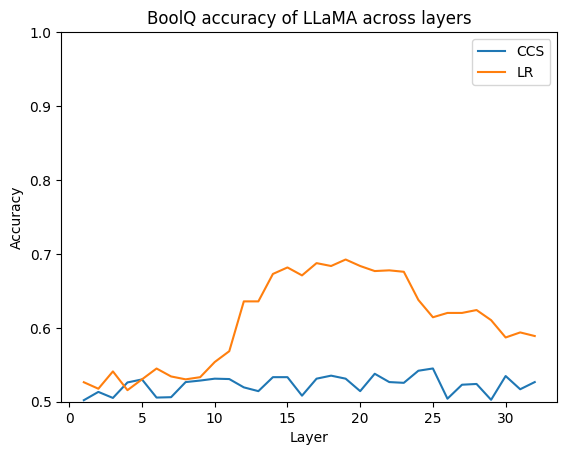

In [9]:
plt.plot(range(1, 33), ccs_accs, label="CCS")
plt.plot(range(1, 33), lr_accs, label="LR")
plt.xlabel("Layer")
plt.ylim(0.5, 1)
plt.ylabel("Accuracy")
plt.legend()
plt.title("BoolQ accuracy of LLaMA across layers")
plt.savefig("boolq_accs.png")
plt.show()

In [16]:
def plot_confusion(confusion_matrix, model_name, save_title=None):
    plt.imshow(confusion_matrix)
    plt.xticks([0, 1], ["False", "True"])
    plt.yticks([0, 1], ["False", "True"])
    plt.xlabel("Predicted")
    plt.ylabel("True label")
    plt.title(f"BoolQ confusion matrix of {model_name}")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="w")
    if save_title is not None:
        plt.savefig(save_title)
    plt.show()

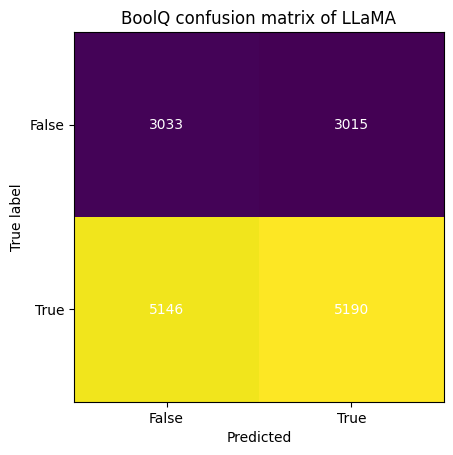

In [17]:
confusion = np.sum(confusions, axis=0)
plot_confusion(confusion, 'LLaMA', "boolq_confusion.png")

In [12]:
def test_random_probe(x_plus, x_minus, y):
    probe = LinearProbe(x_plus.shape[-1])
    return confusion_matrix(y, probe.predict(x_plus, x_minus) > 0.5)

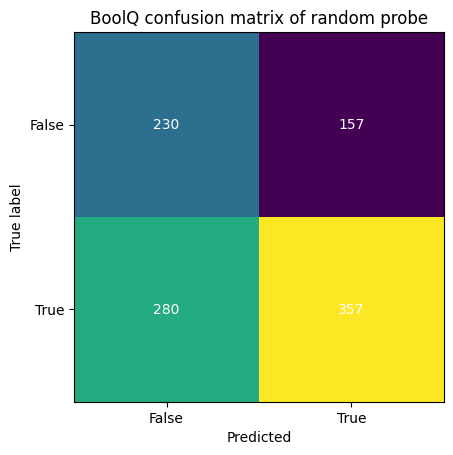

In [20]:
x0, x1, y = dataset[:1024]
confusion = test_random_probe(x0, x1, y)
plot_confusion(confusion, 'random probe', "boolq_random_confusion.png")